# Dataset

/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-30 15:35:56.196142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 15:35:56.204604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:35:56.212497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alread

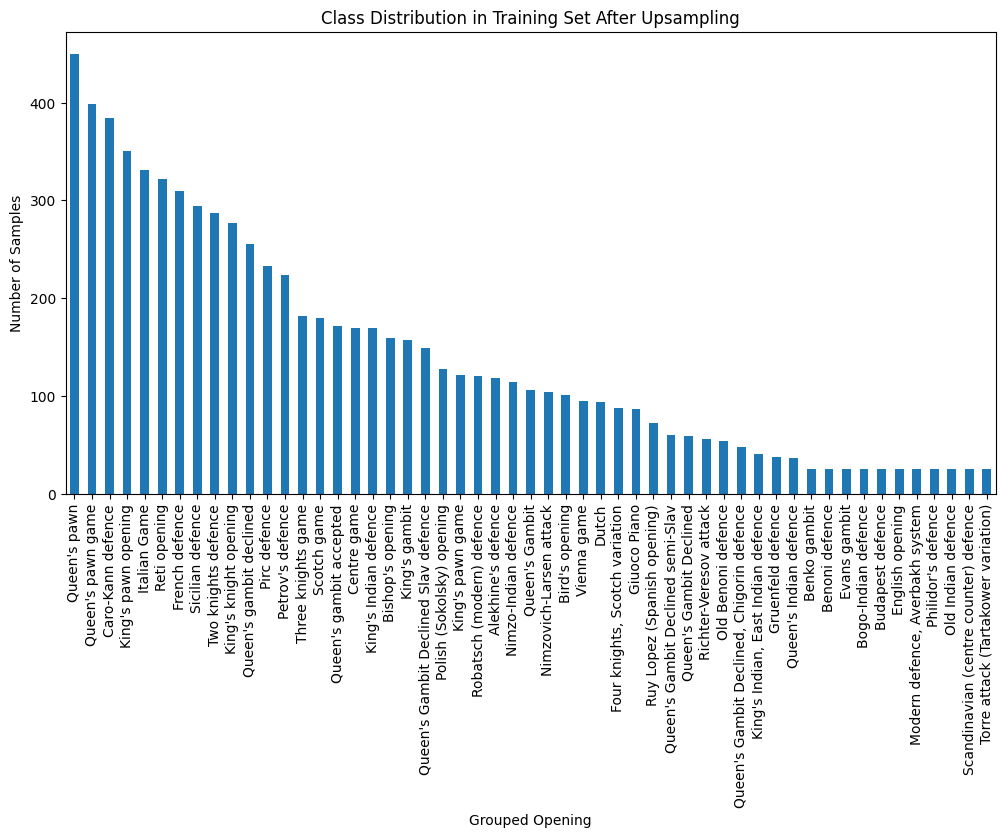

In [1]:
%run DataLoading.py

In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K, Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
with open('chess_X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('chess_X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('chess_y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('chess_y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
y_combined_unique = np.concatenate((unique_classes_train, unique_classes_test))

num_classes = len(np.unique(y_combined_unique))
seq_len = 28

print(X_train.shape)
print(y_train.shape)

input_shape = (seq_len, 8, 8, X_train.shape[4])


(7470, 28, 8, 8, 12)
(7470,)


# CNN -> LSTM Model

Evaluating Combined CNN-LSTM Model...


/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.0350 - loss: 3.8879 
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.0774 - loss: 3.6794 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1151 - loss: 3.5522 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1417 - loss: 3.2877 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.2151 - loss: 3.0081 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.2841 - loss: 2.7001 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3307 - loss: 2.4488 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4039 - loss: 2.2331 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4564 - loss: 1.9879 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4964 - loss: 1.8396 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5345 - loss: 1.6828 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 

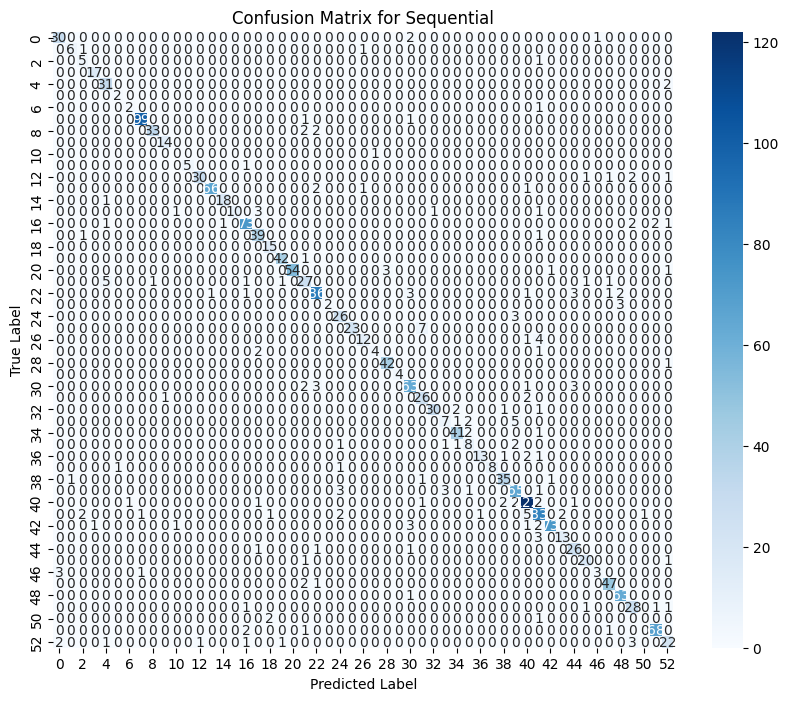

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv3D, Conv2D, Flatten, MaxPooling3D, MaxPooling2D, TimeDistributed, Reshape, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode labels if they are not already encoded
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], seq_len, -1)  # Flattening spatial dimensions and channels
X_test_lstm = X_test.reshape(X_test.shape[0], seq_len, -1)

# Combined CNN-LSTM Model
def create_combined_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # CNN layers
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    # Flatten CNN output
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layers
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluation function for Keras models
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=15):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Define input shape
num_classes = y_train_encoded.shape[1]

# Evaluate the combined CNN-LSTM model
print("Evaluating Combined CNN-LSTM Model...")
cnn_lstm_model = create_combined_cnn_lstm_model((seq_len, 8, 8, 12), num_classes)
evaluate_keras_model(cnn_lstm_model, X_train, y_train_encoded, X_test, y_test_encoded, batch_size=1024, epochs=100)

# CNN -> LSTM w/ Attention Model
https://www.kaggle.com/code/rahulvks/lstm-attention-keras#Building-a-model

In [10]:
from keras.layers import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Custom Attention Layer

Evaluating Combined CNN-LSTM Model...


/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.0413 - loss: 3.8933 
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0676 - loss: 3.6609
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.1223 - loss: 3.4411 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.1949 - loss: 3.2079 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.2614 - loss: 2.9064 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.2929 - loss: 2.6506 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3424 - loss: 2.3994 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3748 - loss: 2.2373 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4185 - loss: 2.0598 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4922 - loss: 1.8570 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5208 - loss: 1.7224 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 

/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


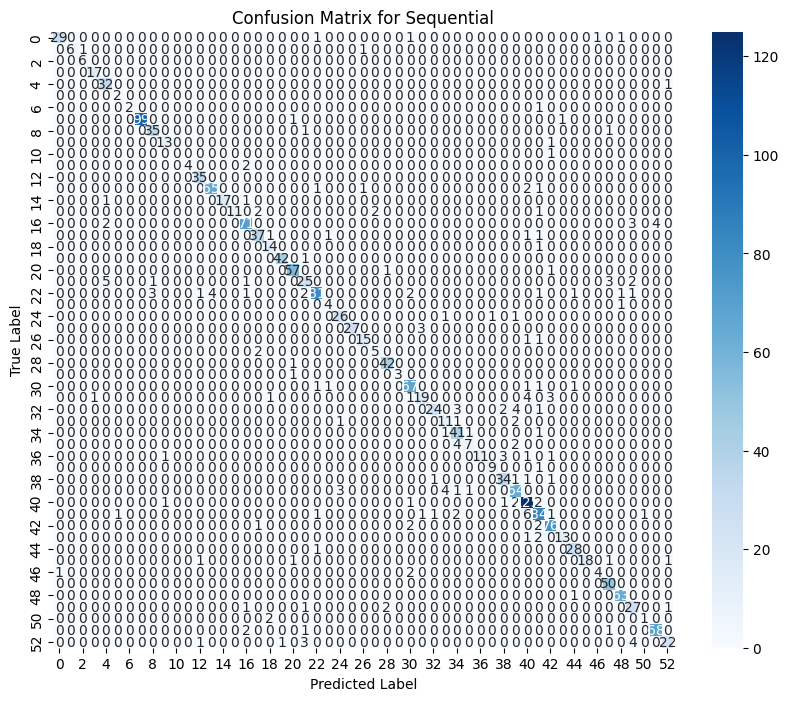

In [12]:
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras

# Encode labels if they are not already encoded
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], seq_len, -1)  # Flattening spatial dimensions and channels
X_test_lstm = X_test.reshape(X_test.shape[0], seq_len, -1)

def create_combined_cnn_lstm_with_attention(input_shape, num_classes, maxlen):
    # CNN Layers
    model_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten and reshape
    x = Flatten()(x)
    x = Reshape((maxlen, -1))(x)  # Adjust based on your input dimensions

    # Attention Layer
    # x = keras.layers.Attention()([x, x])
    x = Attention(step_dim=maxlen)(x)

    # LSTM with Bidirectional wrapper
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)

    # Dense layers
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output Layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=model_input, outputs=output)
    model.compile(optimizer=nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluation function for Keras models
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=15):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Define input shape
num_classes = y_train_encoded.shape[1]

# Evaluate the combined CNN-LSTM model
print("Evaluating Combined CNN-LSTM Model...")
cnn_lstm_attention_model = create_combined_cnn_lstm_model((seq_len, 8, 8, 12), num_classes)
evaluate_keras_model(cnn_lstm_attention_model, X_train, y_train_encoded, X_test, y_test_encoded, batch_size=1024, epochs=100)


## Normal Attention Layer

Evaluating Combined CNN-LSTM Model...


/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0360 - loss: 3.8968 
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.0916 - loss: 3.6645 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.1064 - loss: 3.5042 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.1470 - loss: 3.2606 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.2036 - loss: 2.9378 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.2682 - loss: 2.7030 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3225 - loss: 2.4623 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3605 - loss: 2.3368 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4271 - loss: 2.0964 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4741 - loss: 1.9439 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4839 - loss: 1.8480 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 

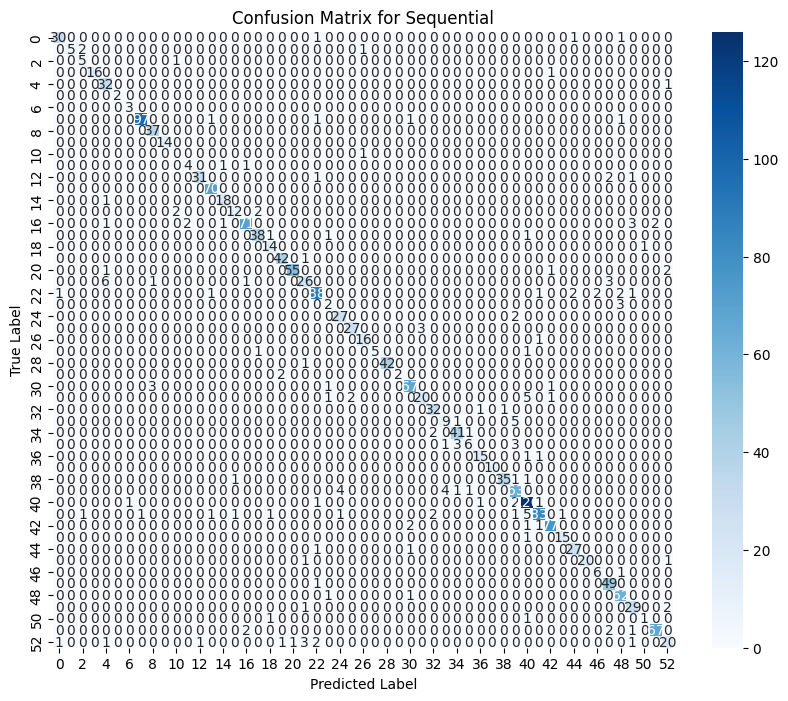

In [11]:
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras

# Encode labels if they are not already encoded
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], seq_len, -1)  # Flattening spatial dimensions and channels
X_test_lstm = X_test.reshape(X_test.shape[0], seq_len, -1)

def create_combined_cnn_lstm_with_attention(input_shape, num_classes, maxlen):
    # CNN Layers
    model_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten and reshape
    x = Flatten()(x)
    x = Reshape((maxlen, -1))(x)  # Adjust based on your input dimensions

    # LSTM with Bidirectional wrapper
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)

    # Attention Layer
    x = keras.layers.Attention()([x, x])
    # x = Attention(step_dim=maxlen)(x)

    # Dense layers
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output Layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=model_input, outputs=output)
    model.compile(optimizer=nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluation function for Keras models
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=15):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Define input shape
num_classes = y_train_encoded.shape[1]

# Evaluate the combined CNN-LSTM model
print("Evaluating Combined CNN-LSTM Model...")
cnn_lstm_attention_model = create_combined_cnn_lstm_model((seq_len, 8, 8, 12), num_classes)
evaluate_keras_model(cnn_lstm_attention_model, X_train, y_train_encoded, X_test, y_test_encoded, batch_size=1024, epochs=100)
